### Importação de Bibliotecas

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd 
import numpy as np

### Leitura e Tratamento dos Dados

In [2]:
jogosCopa   = pd.read_csv('archive/WorldCupMatches.csv',encoding='utf-8')
ranking     = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip')
jogos       = pd.read_csv('archive/results.csv')

In [3]:
jogos = jogos[(jogos["date"] < "2018-08-01")].dropna()

In [4]:
jogos[jogos['home_team']=='Sápmi']

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
29155,2006-11-23,Sápmi,Monaco,14.0,0.0,Viva World Cup,Hyères,France,True
29160,2006-11-24,Sápmi,Monaco,21.0,1.0,Viva World Cup,Hyères,France,True
30765,2008-07-07,Sápmi,Iraqi Kurdistan,2.0,2.0,Viva World Cup,Gällivare,Sweden,False
30769,2008-07-09,Sápmi,Arameans Suryoye,0.0,1.0,Viva World Cup,Gällivare,Sweden,False
30772,2008-07-11,Sápmi,Padania,0.0,2.0,Viva World Cup,Malmberget,Sweden,False
30775,2008-07-12,Sápmi,Provence,4.0,2.0,Viva World Cup,Gällivare,Sweden,False
30776,2008-07-13,Sápmi,Iraqi Kurdistan,3.0,1.0,Viva World Cup,Malmberget,Sweden,False
31692,2009-06-23,Sápmi,Provence,1.0,2.0,Viva World Cup,Varese,Italy,True
31696,2009-06-24,Sápmi,Gozo,7.0,2.0,Viva World Cup,Brescia,Italy,True
36362,2014-06-02,Sápmi,Abkhazia,1.0,2.0,CONIFA World Football Cup,Östersund,Sweden,False


In [5]:
jogos.groupby(['home_team'])['home_score'].mean().sort_values(ascending=False).head(50)

home_team
Sápmi                        4.125000
Cascadia                     4.000000
North Vietnam                3.600000
Micronesia                   3.500000
Yorkshire                    3.500000
Somaliland                   3.500000
Northern Cyprus              3.409091
Kárpátalja                   3.400000
Gotland                      3.350000
Western Sahara               3.333333
Isle of Man                  3.157895
Székely Land                 3.125000
Tahiti                       3.021739
Panjab                       3.000000
Silesia                      3.000000
Western Australia            3.000000
Menorca                      2.909091
Solomon Islands              2.819444
New Caledonia                2.810606
Canary Islands               2.750000
Fiji                         2.744681
Western Isles                2.666667
Wallis Islands and Futuna    2.666667
Guernsey                     2.628571
Tamil Eelam                  2.571429
Basque Country               2.548387
Je

In [6]:
jogos

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
40294,2018-07-10,France,Belgium,1.0,0.0,FIFA World Cup,Saint Petersburg,Russia,True
40295,2018-07-11,Croatia,England,2.0,1.0,FIFA World Cup,Moscow,Russia,True
40296,2018-07-14,Belgium,England,2.0,0.0,FIFA World Cup,Saint Petersburg,Russia,True
40297,2018-07-15,France,Croatia,4.0,2.0,FIFA World Cup,Moscow,Russia,True


In [114]:
import pandas as pd
import re
df =  pd.read_csv('archive/results.csv') #games between national teams
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) #games at the 2022 wc cycle
df_wc = df #pre-wc outcomes

rank = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip') #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked.dropna(inplace=True)

In [115]:
#Target -> 1 Vitoria da Casa,2 Vitoria  do visitante e 0  empate
df_wc_ranked['Target'] = np.where(df_wc_ranked['home_score']>df_wc_ranked['away_score'],1,
                         np.where(df_wc_ranked['home_score']<df_wc_ranked['away_score'],2,0))

In [116]:
df_wc_ranked['flag_amistoso'] = np.where(df_wc_ranked['tournament']=='Friendly',1,0)

In [117]:
df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['home_team'])
df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['away_team'],suffixes=("_home", "_away")).drop(['TargetCopa_home','TargetCopa_away'],axis=1).fillna(0)

In [119]:
df_wc_ranked

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,Target,flag_amistoso,QtdCopas_home,QtdCopas_away
0,2018-08-18,Andorra,United Arab Emirates,0.0,0.0,Friendly,Grödig,Austria,True,1120.00,...,130.0,0.0,1312.00,1312.00,77.0,0.0,0,1,0.0,0.0
1,2018-08-18,Grenada,Jamaica,1.0,5.0,Friendly,St. George's,Grenada,False,980.00,...,168.0,0.0,1400.00,1400.00,54.0,0.0,2,1,0.0,0.0
2,2018-08-18,Guatemala,Cuba,1.0,0.0,Friendly,Quetzaltenango,Guatemala,False,1064.00,...,146.0,0.0,940.00,940.00,181.0,0.0,1,1,0.0,0.0
3,2018-08-20,Barbados,Jamaica,2.0,2.0,Friendly,Bridgetown,Barbados,False,1005.00,...,160.0,0.0,1400.00,1400.00,54.0,0.0,0,1,0.0,0.0
4,2018-08-26,Barbados,Cuba,0.0,0.0,Friendly,Bridgetown,Barbados,False,1005.00,...,160.0,0.0,940.00,940.00,181.0,0.0,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,2022-09-27,Albania,Iceland,1.0,1.0,UEFA Nations League,Tirana,Albania,False,1361.81,...,66.0,0.0,1379.61,1379.61,63.0,0.0,0,0,0.0,0.0
3331,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,...,36.0,0.0,1549.53,1549.53,25.0,0.0,2,0,0.0,0.0
3332,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,...,20.0,0.0,1372.48,1372.48,65.0,0.0,0,0,0.0,0.0
3333,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,...,106.0,0.0,1180.52,1180.52,108.0,1.0,1,0,0.0,0.0


In [120]:
X = df_wc_ranked.loc[:,'total_points_home':].drop('Target',axis=1)
Y =  df_wc_ranked[['Target']]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2)

In [123]:
rf = RandomForestClassifier(random_state=2,max_depth=10) 
model_rf = rf.fit(X_train,y_train)

/tmp/ipykernel_57387/3904952759.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf = rf.fit(X_train,y_train)


In [124]:
predict = model_rf.predict(X_test)
print(accuracy_score(predict,y_test)*100)

54.845154845154845


In [125]:
X.columns

Index(['total_points_home', 'previous_points_home', 'rank_home',
       'rank_change_home', 'total_points_away', 'previous_points_away',
       'rank_away', 'rank_change_away', 'flag_amistoso', 'QtdCopas_home',
       'QtdCopas_away'],
      dtype='object')

In [127]:
features = ['total_points_home', 'previous_points_home', 'rank_home',
       'rank_change_home', 'total_points_away', 'previous_points_away',
       'rank_away', 'rank_change_away', 'flag_amistoso','QtdCopas_home',
       'QtdCopas_away']

In [128]:
features_importance = zip(model_rf.feature_importances_, features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

total_points_home: 15.649396%
previous_points_home: 15.497880%
total_points_away: 14.449023%
previous_points_away: 13.479614%
rank_home: 12.645181%
rank_away: 12.546491%
rank_change_away: 5.976758%
rank_change_home: 5.878216%
flag_amistoso: 1.585755%
QtdCopas_away: 1.355963%
QtdCopas_home: 0.935725%


In [78]:
jogosCopa = jogosCopa.drop_duplicates('MatchID')
jogosCopa = jogosCopa.dropna()
jogosCopa = jogosCopa.loc[:,['Year', 'Stage', 'Home Team Name',
  'Home Team Goals', 'Away Team Goals','Win conditions','Away Team Name',
  'Attendance', 'Half-time Home Goals','Half-time Away Goals',
  'RoundID', 'MatchID']]
jogosCopa = jogosCopa.replace('Germany FR','Germany')

In [79]:
jogosCopa['TargetCopa'] = np.where(jogosCopa['Home Team Goals']>jogosCopa['Away Team Goals'],jogosCopa['Home Team Name'],
                      np.where(jogosCopa['Home Team Goals']<jogosCopa['Away Team Goals'],jogosCopa['Away Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Home Team Name'] in x['Win conditions'],axis=1),jogosCopa['Home Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Away Team Name'] in x['Win conditions'],axis=1),jogosCopa['Away Team Name'],
                      'Empate'
                    ))))

In [81]:
#Quantidade de Copas Ganhas
vencedores = jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).to_frame('QtdCopas').reset_index()

In [37]:
#Quantidade de Vezes que foi para final
finalistas = pd.concat([jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count(),
                        jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()])


In [82]:
vencedores

,TargetCopa,QtdCopas
0,Brazil,5
1,Germany,4
2,Italy,4
3,Argentina,2
4,England,1
5,France,1
6,Spain,1
7,Uruguay,1


In [81]:
ranking.groupby(['country_full'])['rank_change'].mean().sort_values(ascending=False).head(10)

country_full
Kosovo                      1.796610
South Sudan                 1.537736
Türkiye                     1.500000
São Tomé e Príncipe         1.000000
St. Vincent / Grenadines    0.579710
Serbia and Montenegro       0.395349
Bermuda                     0.344720
San Marino                  0.310204
Malta                       0.295031
São Tomé and Príncipe       0.260870
Name: rank_change, dtype: float64

In [84]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64

### Variaveis
    var = { 'QTD_COPAS' :0, ✅
            'QtdFinais' :0, ✅
            'QtdSemi'   :0, ✅
            'Ranking'   :0, ✅
            'GOLS_COPAS':0,
            'Vit_5ULT_J':0,
            'Gol_5ULT_J':0
            'VitPorPub': JogVit/Pub
            
    }

In [137]:
vencedores

,TargetCopa,QtdCopas
0,Brazil,5
1,Germany,4
2,Italy,4
3,Argentina,2
4,England,1
5,France,1
6,Spain,1
7,Uruguay,1


In [141]:
baseDados 

,Year,Stage,Home Team Name,Home Team Goals,Away Team Goals,Win conditions,Away Team Name,Attendance,Half-time Home Goals,Half-time Away Goals,RoundID,MatchID,TargetCopa,QtdCopas
0,1930.0,Group 1,France,4.0,1.0,,Mexico,4444.0,3.0,0.0,201.0,1096.0,France,1.0
1,1930.0,Group 4,USA,3.0,0.0,,Belgium,18346.0,2.0,0.0,201.0,1090.0,USA,NaN
2,1930.0,Group 2,Yugoslavia,2.0,1.0,,Brazil,24059.0,2.0,0.0,201.0,1093.0,Yugoslavia,NaN
3,1930.0,Group 3,Romania,3.0,1.0,,Peru,2549.0,1.0,0.0,201.0,1098.0,Romania,NaN
4,1930.0,Group 1,Argentina,1.0,0.0,,France,23409.0,0.0,0.0,201.0,1085.0,Argentina,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,2014.0,Quarter-finals,Argentina,1.0,0.0,,Belgium,68551.0,1.0,0.0,255953.0,300186504.0,Argentina,2.0
831,2014.0,Round of 16,Netherlands,2.0,1.0,,Mexico,58817.0,0.0,0.0,255951.0,300186508.0,Netherlands,NaN
832,2014.0,Round of 16,Costa Rica,1.0,1.0,Costa Rica win on penalties (5 - 3),Greece,41242.0,0.0,0.0,255951.0,300186459.0,Costa Rica,NaN
833,2014.0,Round of 16,Argentina,1.0,0.0,Argentina win after extra time,Switzerland,63255.0,0.0,0.0,255951.0,300186503.0,Argentina,2.0


<AxesSubplot: xlabel='TargetCopa'>

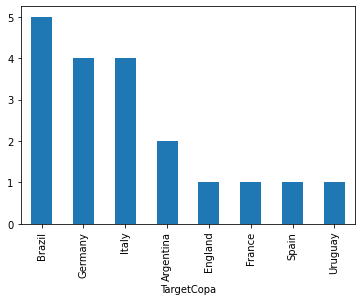

In [59]:
jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).plot.bar()

In [65]:
#Quantidade de Vezes que foi para final
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           8.0
Brazil            6.0
Italy             6.0
Argentina         5.0
Netherlands       3.0
Czechoslovakia    1.0
England           1.0
France            1.0
Hungary           1.0
Spain             1.0
Sweden            1.0
Uruguay           1.0
dtype: float64

<AxesSubplot: >

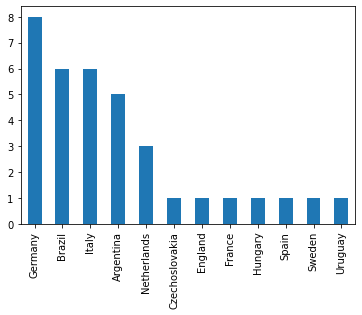

In [66]:
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar

In [101]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()

Away Team Name
Argentina         2
Austria           2
Belgium           1
Brazil            2
Chile             1
Croatia           1
England           1
France            3
Germany           5
Italy             3
Korea Republic    1
Netherlands       2
Portugal          1
Soviet Union      1
Spain             1
Sweden            1
Turkey            1
USA               1
Uruguay           2
Yugoslavia        2
Name: Away Team Name, dtype: int64

In [99]:
#Quantidade de vezes que foi para Semifinais
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           12.0
Brazil             8.0
Italy              7.0
France             5.0
Uruguay            4.0
Argentina          4.0
Sweden             3.0
Netherlands        3.0
Portugal           2.0
England            2.0
Croatia            1.0
Belgium            1.0
USA                1.0
Turkey             1.0
Spain              1.0
Soviet Union       1.0
Poland             1.0
Czechoslovakia     1.0
Korea Republic     1.0
Austria            1.0
Hungary            1.0
Bulgaria           1.0
Chile              1.0
Yugoslavia         1.0
dtype: float64

In [100]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Away Team Name'].count()

Home Team Name
Argentina         2
Brazil            6
Bulgaria          1
Czechoslovakia    2
England           1
France            2
Germany           7
Hungary           2
Italy             4
Netherlands       1
Poland            1
Portugal          1
Sweden            2
Uruguay           2
Name: Away Team Name, dtype: int64

<AxesSubplot: >

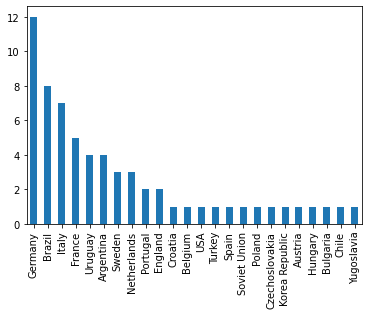

In [102]:
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar()

In [87]:
jogosCopa

,Year,Stage,Home Team Name,Home Team Goals,Away Team Goals,Win conditions,Away Team Name,Attendance,Half-time Home Goals,Half-time Away Goals,RoundID,MatchID,TargetCopa
0,1930.0,Group 1,France,4.0,1.0,,Mexico,4444.0,3.0,0.0,201.0,1096.0,France
1,1930.0,Group 4,USA,3.0,0.0,,Belgium,18346.0,2.0,0.0,201.0,1090.0,USA
2,1930.0,Group 2,Yugoslavia,2.0,1.0,,Brazil,24059.0,2.0,0.0,201.0,1093.0,Yugoslavia
3,1930.0,Group 3,Romania,3.0,1.0,,Peru,2549.0,1.0,0.0,201.0,1098.0,Romania
4,1930.0,Group 1,Argentina,1.0,0.0,,France,23409.0,0.0,0.0,201.0,1085.0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2014.0,Quarter-finals,Argentina,1.0,0.0,,Belgium,68551.0,1.0,0.0,255953.0,300186504.0,Argentina
832,2014.0,Round of 16,Netherlands,2.0,1.0,,Mexico,58817.0,0.0,0.0,255951.0,300186508.0,Netherlands
833,2014.0,Round of 16,Costa Rica,1.0,1.0,Costa Rica win on penalties (5 - 3),Greece,41242.0,0.0,0.0,255951.0,300186459.0,Costa Rica
834,2014.0,Round of 16,Argentina,1.0,0.0,Argentina win after extra time,Switzerland,63255.0,0.0,0.0,255951.0,300186503.0,Argentina


In [95]:
# (jogosCopa.groupby(['Home Team Name'])['Home Team Goals'].sum() +\
jogosCopa.groupby(['Away Team Name'])['Away Team Goals'].sum()
# ).sort_values(ascending=False)


Away Team Name
Algeria                        7.0
Angola                         1.0
Argentina                     22.0
Australia                      4.0
Austria                       12.0
                              ... 
rn">Bosnia and Herzegovina     1.0
rn">Republic of Ireland        8.0
rn">Serbia and Montenegro      2.0
rn">Trinidad and Tobago        0.0
rn">United Arab Emirates       2.0
Name: Away Team Goals, Length: 82, dtype: float64

In [76]:
ranking.groupby(['country_full'])['rank'].mean().sort_values().head(10)

country_full
Brazil          3.111801
Spain           5.580745
Argentina       5.745342
Germany         5.975155
France          8.273292
Italy           8.701863
Netherlands     9.363354
England         9.962733
Portugal       10.894410
Mexico         14.512422
Name: rank, dtype: float64

In [49]:

# copa  = pd.read_csv('')

In [53]:
jogosCopa

,Year,Stage,Home Team Name,Home Team Goals,Away Team Goals,Away Team Name,Attendance,Half-time Home Goals,Half-time Away Goals,RoundID,MatchID,Target
0,1930.0,Group 1,France,4.0,1.0,Mexico,4444.0,3.0,0.0,201.0,1096.0,France
1,1930.0,Group 4,USA,3.0,0.0,Belgium,18346.0,2.0,0.0,201.0,1090.0,USA
2,1930.0,Group 2,Yugoslavia,2.0,1.0,Brazil,24059.0,2.0,0.0,201.0,1093.0,Yugoslavia
3,1930.0,Group 3,Romania,3.0,1.0,Peru,2549.0,1.0,0.0,201.0,1098.0,Romania
4,1930.0,Group 1,Argentina,1.0,0.0,France,23409.0,0.0,0.0,201.0,1085.0,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...
831,2014.0,Quarter-finals,Argentina,1.0,0.0,Belgium,68551.0,1.0,0.0,255953.0,300186504.0,Argentina
832,2014.0,Round of 16,Netherlands,2.0,1.0,Mexico,58817.0,0.0,0.0,255951.0,300186508.0,Netherlands
833,2014.0,Round of 16,Costa Rica,1.0,1.0,Greece,41242.0,0.0,0.0,255951.0,300186459.0,Empate
834,2014.0,Round of 16,Argentina,1.0,0.0,Switzerland,63255.0,0.0,0.0,255951.0,300186503.0,Argentina


In [40]:
jogosCopa['Home Team Name'].unique()

array(['France', 'USA', 'Yugoslavia', 'Romania', 'Argentina', 'Chile',
       'Uruguay', 'Brazil', 'Paraguay', 'Austria', 'Hungary',
       'Switzerland', 'Sweden', 'Germany', 'Spain', 'Italy',
       'Czechoslovakia', 'Cuba', 'England', 'Germany FR', 'Turkey',
       'Soviet Union', 'Northern Ireland', 'Mexico', 'Wales', 'Portugal',
       'Korea DPR', 'Peru', 'Belgium', 'Bulgaria', 'German DR', 'Zaire',
       'Poland', 'Australia', 'Scotland', 'Netherlands', 'Haiti',
       'Tunisia', 'Algeria', 'Honduras', 'Canada', 'Morocco',
       'Korea Republic', 'Iraq', 'Denmark', 'rn">United Arab Emirates',
       'Costa Rica', 'Cameroon', 'rn">Republic of Ireland', 'Colombia',
       'Norway', 'Nigeria', 'Saudi Arabia', 'Bolivia', 'Russia', 'Greece',
       'Jamaica', 'South Africa', 'Japan', 'Croatia', 'China PR',
       'Senegal', 'Slovenia', 'Ecuador', 'rn">Trinidad and Tobago',
       'rn">Serbia and Montenegro', 'Angola', 'Czech Republic', 'Togo',
       'Iran', "C�te d'Ivoire", 'Ghana

In [54]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64